In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('talk')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as OUTPUT_DIRECTORY_MAIN

OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY_MAIN, 'preprocessing')
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [3]:
from snapanalysis.preprocessing.cleanup.main import OUTPUT_FILE as ENRICHMENT_MODEL_INPUT
from snapanalysis.models.enrichment.generate import RATIO_COLUMN
from snapanalysis.models.enrichment.generate import rotate, EnrichmentDecoposition
from snapanalysis.models.enrichment.generate import OUTPUT_FILE as ENRICHMENT_OUTPUT

In [4]:
enrichment_data = pd.read_hdf(ENRICHMENT_OUTPUT, 'enrichment_data')

In [5]:
pulldown_data = pd.read_hdf(ENRICHMENT_MODEL_INPUT, 'pulldown_data')
pulldown_data_unstacked = pulldown_data.unstack('Direction')
pulldown_data_unstacked.sort_index(inplace=True)

ratios = pulldown_data_unstacked[RATIO_COLUMN].dropna()

abs_max = ratios.abs().max().max()
limit = 1.1 * abs_max

In [6]:
POINT_COLOR = '#666666'
POINT_COLOR_HIGHLIGHT = '#CF4457'

ACCENT_COLOR = '#E54275'
ACCENT_COLOR_2 = '#3B6BAA'
ACCENT_COLOR_3 = '#F0B52A'
ACCENT_COLOR_DIM = '#F77C75'


# Helpers

In [7]:
from matplotlib.font_manager import FontProperties
import math

def zero_lines(ax=None, color='k', linewidth=.5, zorder=1, **kwargs):

    ax.axhline(0, color=color, linewidth=linewidth, zorder=zorder, **kwargs)
    ax.axvline(0, color=color, linewidth=linewidth, zorder=zorder, **kwargs)

TITLE_FONT = FontProperties()
TITLE_FONT.set_family('helvetica')
TITLE_FONT.set_weight('bold')
TITLE_FONT.set_size(15)

ANNOTATION_FONT = FontProperties()
ANNOTATION_FONT.set_family('helvetica')
ANNOTATION_FONT.set_size(10)

def plot_title(pull_down_ids, ax=None, color=None, label=None, pos='bottom', **kwargs):
    if ax is None:
        ax = plt.gca()

    pull_down_ids = np.unique(pull_down_ids)
    assert len(pull_down_ids) == 1
    
    
    pull_down_id = pull_down_ids[0]
    
    if pos == 'bottom':
        y = 0.05
        va = 'bottom'
    else:
        y = 0.95
        va = 'top'
    
    ax.text(0.05, y, pull_down_id,
            color='black',
            horizontalalignment='left',
            verticalalignment=va,
            transform=ax.transAxes,
            fontproperties=TITLE_FONT)
    
def plot_angle(angle, ax=None, color=None, label=None, 
               name=None,
               linestyle=':',
               length=np.sqrt(np.square((2*abs_max))),
               annot_pos=0, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    if name is None:
        name = angle.name
    
    angle = np.unique(angle)
    assert len(angle) == 1
    angle = angle[0]
    
    angle_deg = math.degrees(angle)
    
    x = np.cos(-angle) * length
    y = np.sin(-angle) * length

    ax.plot([-x, x], [-y, y], color=color, linestyle=linestyle, **kwargs)
    
    ax.text(0.98, 
            0.98 - 0.07 * annot_pos, 
            f'{name}: {angle_deg:.2f}°',
            color=color,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes,
            fontproperties=ANNOTATION_FONT)

def plot_angle_arrow(angle, ax=None, label=None, 
                     text=None,
                     length=10,
                     text_kws=None,
                     **kwargs):
    if ax is None:
        ax = plt.gca()
   
    
    angle = np.unique(angle)
    assert len(angle) == 1
    angle = angle[0]
    
    angle_deg = math.degrees(angle)
    
    x = np.cos(-angle) * length
    y = np.sin(-angle) * length
    
    # Suggested by the documentation
    kwargs.setdefault('arrowprops', dict(arrowstyle='->'))
    
    ax.annotate("", xytext=(-x, -y), xy=(x, y),
                **kwargs)

    # We draw the arrow in reverse way so need to add our own text
    if text is not None:
        if text_kws is None:
            text_kws = dict()
            
        ax.text(x, y, text, **text_kws)

# Diagonal

In [8]:
import palettable
# Inliers is the same for all so just do that once
__, rotated, inliers = rotate(ratios)

angles = {}
for method in ['estimated']:
    _angles, __, __ = rotate(ratios)
    angles[method] = _angles
    
angles = pd.DataFrame(angles)
palette = dict(zip(angles.columns, palettable.cartocolors.qualitative.Bold_4_r.hex_colors))

In [9]:
order = (angles['estimated'] - np.pi/4).abs().sort_values(ascending=False).index

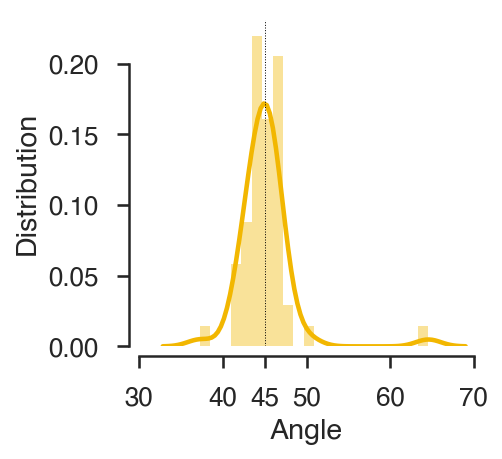

In [10]:
fig = plt.figure(figsize=(3,3))

ax = plt.gca()
sns.distplot(np.rad2deg(angles['estimated']), color='#F2B701', ax=ax)
# ax.axvline(45, color='#F2B701')

ax.set_xlabel('Angle')
ax.set_ylabel('Distribution')
ax.set_xlim(30, 70)
ax.set_xticks([30, 40, 45, 50, 60, 70])
ax.axvline(45, linestyle=':', linewidth=0.5, color='k')
sns.despine(ax=ax, offset=5, trim=True)
ax.grid(False)

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'rotation-angle-distribution.pdf'), bbox_inches='tight')

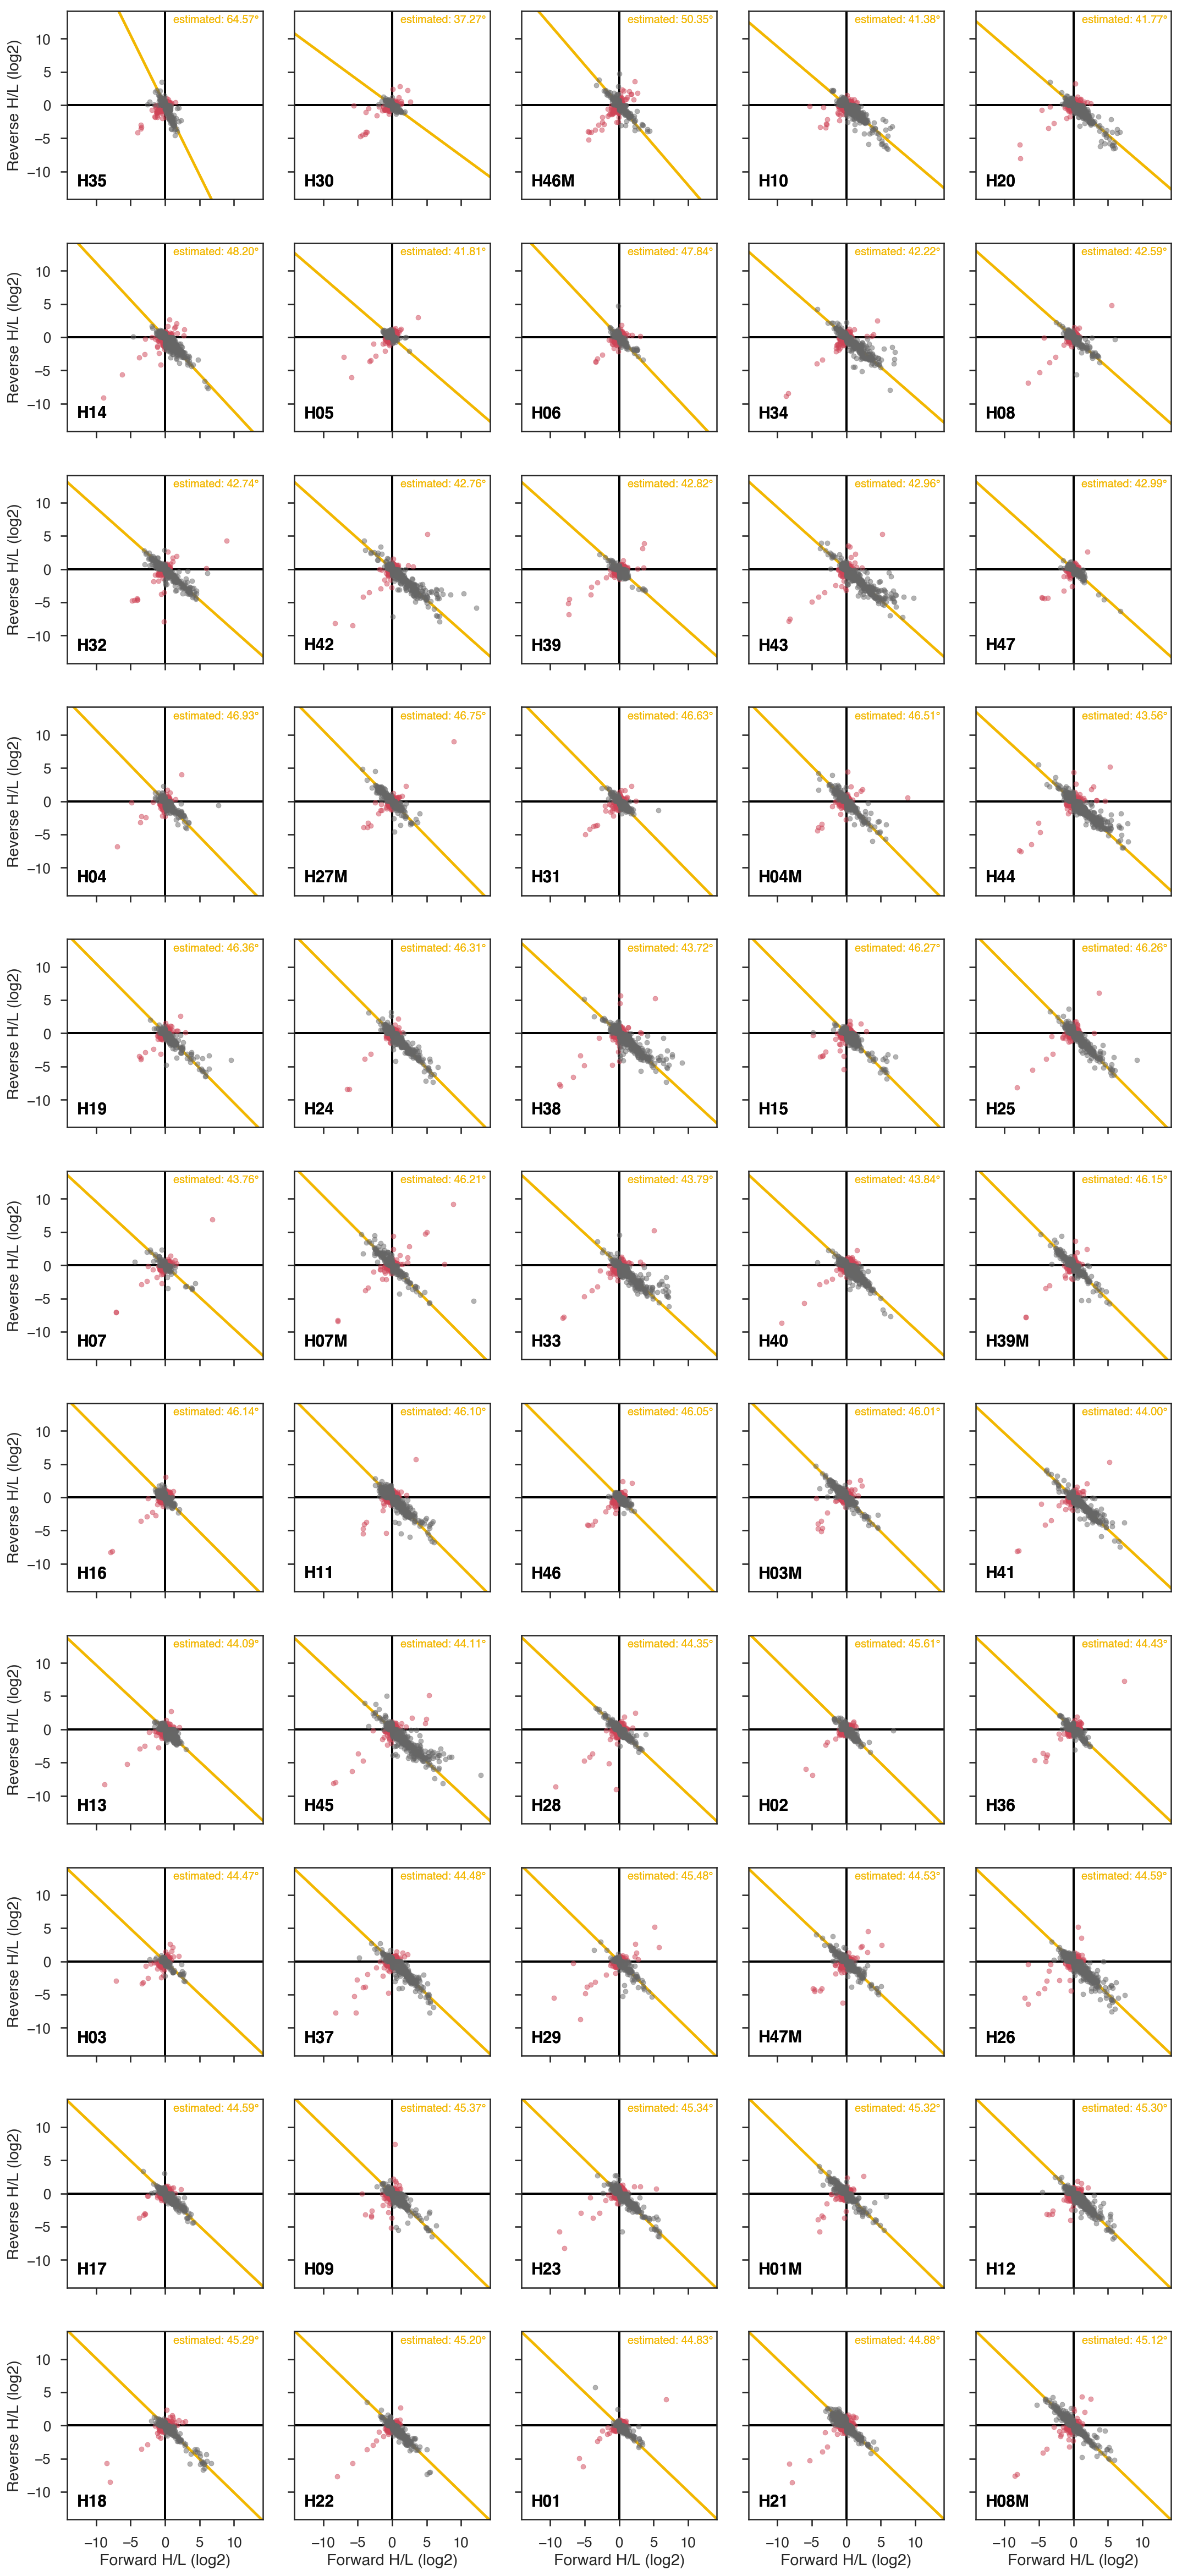

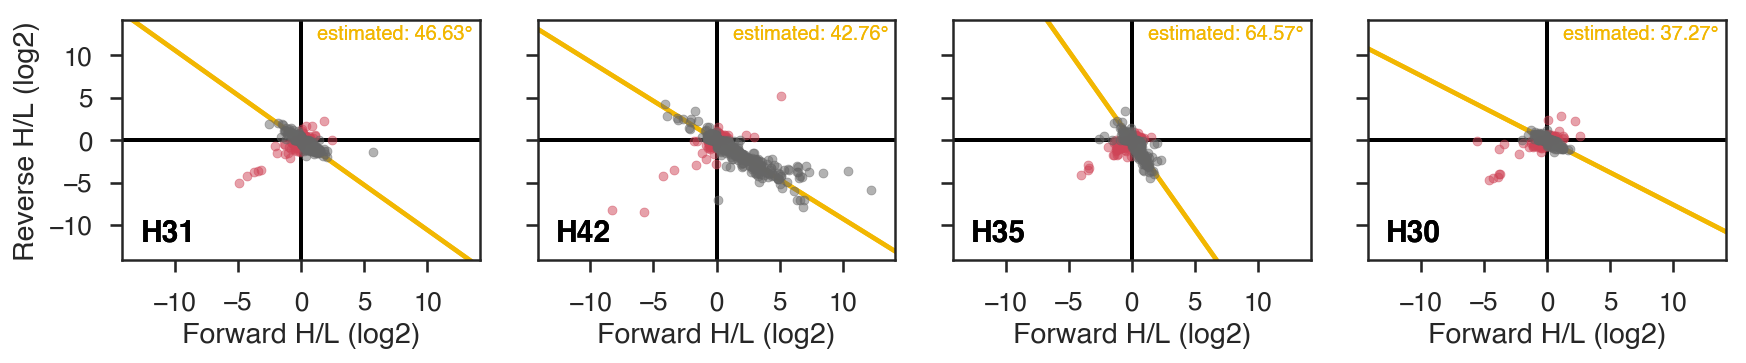

In [11]:
_df = ratios.join(inliers).join(angles).reset_index()


for mode, subset in [
    ('full', order),
    ('subset', ['H31', 'H42', 'H35', 'H30'])]:

    fgrid = sns.FacetGrid(data=_df, col='Pull-Down ID', hue='is_inlier',
                          palette={False: POINT_COLOR_HIGHLIGHT, True: POINT_COLOR},
                          col_order=subset,
                          col_wrap=5)
    fgrid.map(plt.scatter, 'forward', 'reverse',
              alpha=.5,
              zorder=2, s=20, rasterized=True)

    for i, angle_col in enumerate(angles.columns):
        fgrid.map(plot_angle, angle_col, color=palette[angle_col], linestyle='-', annot_pos=i, zorder=1)

    fgrid.map(plot_title, 'Pull-Down ID')

    fgrid.set_xlabels('Forward H/L (log2)')
    fgrid.set_ylabels('Reverse H/L (log2)')
    fgrid.set_titles('')

    for i, ax in enumerate(fgrid.axes):
        for side in ['top', 'right', 'left', 'bottom']:
            ax.spines[side].set_visible(True)

        zero_lines(ax=ax, linewidth=2)
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.grid(False)
        ax.set_xticks([-10, -5, 0, 5, 10])
        ax.set_yticks([-10, -5, 0, 5, 10])
        ax.title.set_visible(False)
        
    fgrid.savefig(os.path.join(OUTPUT_DIRECTORY, f'diagonal-inferences-grid-{mode}.pdf'))
#     plt.close()

# Enrichment-residual explanation

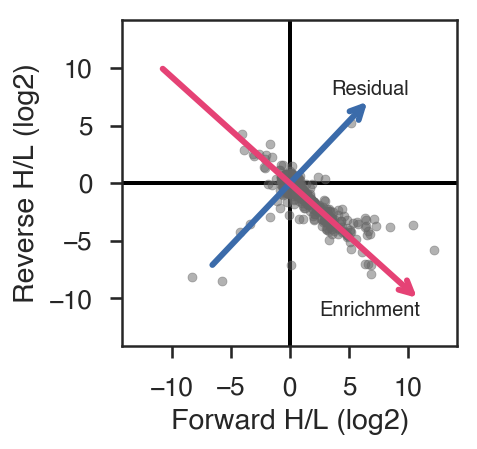

In [12]:
_df = ratios.join(inliers).join(angles).reset_index()
# I think seaborn facetgrid is buggy when only one factor present
_df = _df[_df['Pull-Down ID'] == 'H42']

fig = plt.figure(figsize=(3,3))
ax = plt.gca()

ax.scatter(_df['forward'], _df['reverse'],
           alpha=.5, color=POINT_COLOR,
           zorder=2, s=20, rasterized=True)

plot_angle_arrow(_df['estimated']-np.pi/2, 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color=ACCENT_COLOR_2),
                 length=10,
                 zorder=3,
                 text='Residual',
                 text_kws=dict(ha='center', va='bottom', fontsize=10),
                 ax=ax)

plot_angle_arrow(_df['estimated'], 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color=ACCENT_COLOR),
                 length=15,
                 text='Enrichment',
                 text_kws=dict(ha='right', va='top', fontsize=10),
                 zorder=3, ax=ax)


# plot_title(_df['Pull-Down ID'], ax=ax)

ax.set_xlabel('Forward H/L (log2)')
ax.set_ylabel('Reverse H/L (log2)')
ax.set_title('')


for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)

zero_lines(ax=ax, linewidth=2)
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.grid(False)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.title.set_visible(False)

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'enrichment-residual-explanation.pdf'), bbox_inches='tight')

# Imputation explanation

In [13]:
missing_data_types = enrichment_data['Missing data type'].value_counts()

for type_, count in missing_data_types.items():
    pct = count / len(enrichment_data)
    print(f'{type_}: {count:,} ({pct:.2%})')

one ratio: 9,619 (9.11%)
three: 68 (0.06%)
reverse: 19 (0.02%)
forward: 18 (0.02%)
background: 6 (0.01%)
heavy: 2 (0.00%)
light: 1 (0.00%)


In [14]:
imputation_vcs = enrichment_data['Imputation type'].value_counts()

for type_, count in imputation_vcs.items():
    pct = count / len(enrichment_data)
    print(f'{type_}: {count:,} ({pct:.2%})')

zero-fill: 25,836 (24.47%)
ratio projection: 9,619 (9.11%)
max enrichment: 6 (0.01%)


In [15]:
n_imputed_per_gene = enrichment_data['Imputation type'].groupby(level='Gene label').apply(lambda x: len(x) - (x.isnull()).sum())

In [16]:
print('{:,}/{:,} ({:.2%})'.format((n_imputed_per_gene > 0).sum(), len(n_imputed_per_gene), 
                                  (n_imputed_per_gene > 0).sum() / len(n_imputed_per_gene)))

1,311/1,920 (68.28%)


42.76


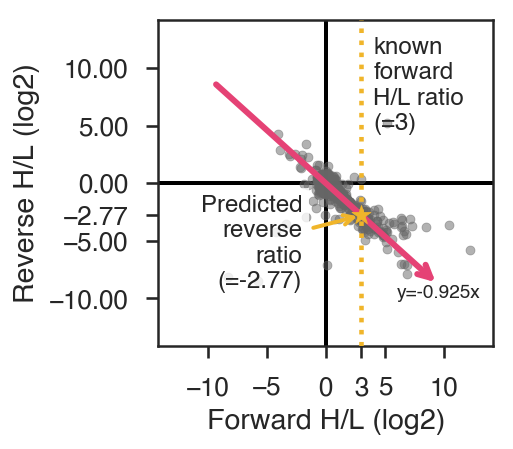

In [17]:
import matplotlib.transforms as transforms

_df = ratios.join(inliers).join(angles).reset_index()
# I think seaborn facetgrid is buggy when only one factor present
_df = _df[_df['Pull-Down ID'] == 'H42']

fig = plt.figure(figsize=(3,3))
ax = plt.gca()

ax.scatter(_df['forward'], _df['reverse'],
           alpha=.5, color=POINT_COLOR,
           zorder=2, s=20, rasterized=True)

angle = np.unique(_df['estimated'])[0]


_x = 3
_y = np.tan(-angle) * _x
angle_degrees = np.rad2deg(angle)
print(f'{angle_degrees:.2f}')
angle_neg_tangent = - np.tan(angle)

ax.scatter(_x, _y, marker='*', zorder=4, color=ACCENT_COLOR_3, s=100)
ax.axvline(_x, linestyle=':', color=ACCENT_COLOR_3, zorder=3)

trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)
ax.text(_x + 1, 0.95, 
        f'known\nforward\nH/L ratio\n(={_x})',
        ha='left', va='top',
        fontsize=12,
        transform=trans)

ax.annotate(f"Predicted\nreverse\nratio\n(={_y:.2f})", 
            xytext=(_x-5, _y-2.5), 
            xy=(_x, _y),
            ha='right', va='center',
            bbox =dict(boxstyle="square,pad=0.3", fc="white", alpha=.8, linewidth=0),
            fontsize=12,
            arrowprops=dict(arrowstyle='->', linewidth=2, color=ACCENT_COLOR_3))



plot_angle_arrow(_df['estimated'], 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color=ACCENT_COLOR),
                 length=13.0,
                 text=f'y={angle_neg_tangent:.3f}x',
                 text_kws=dict(ha='center', va='top', fontsize=9.5),
                 zorder=3, ax=ax)


# plot_title(_df['Pull-Down ID'], ax=ax)

ax.set_xlabel('Forward H/L (log2)')
ax.set_ylabel('Reverse H/L (log2)')
ax.set_title('')


for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)

zero_lines(ax=ax, linewidth=2)
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.grid(False)
ax.set_xticks([-10, -5, 0, _x, 5, 10])
ax.set_yticks([-10, -5,_y, 0, 5, 10])
ax.title.set_visible(False)

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'imputation-explanation.pdf'), bbox_inches='tight')

In [18]:
_df = enrichment_data['Imputation type'].fillna('not imputed')
_df = _df.reset_index().groupby(['Pull-Down ID', 'Imputation type'])['Gene label'].nunique()
_df = _df.unstack('Imputation type').fillna(0).astype(int)

In [19]:
_df

Imputation type,max enrichment,not imputed,ratio projection,zero-fill
Pull-Down ID,,,,
H01,0,1602,120,198
H01M,0,1070,184,666
H02,0,1569,123,228
H03,0,1528,152,240
H03M,0,1032,215,673
H04,0,1506,137,277
H04M,0,1048,221,651
H05,0,1526,131,263
H06,0,1513,146,261


In [20]:
_df.sum()

Imputation type
max enrichment          6
not imputed         70139
ratio projection     9619
zero-fill           25836
dtype: int64

In [21]:
_df.sum() / _df.sum().sum()

Imputation type
max enrichment      0.000057
not imputed         0.664195
ratio projection    0.091089
zero-fill           0.244659
dtype: float64

# Enrichment rotation explanation

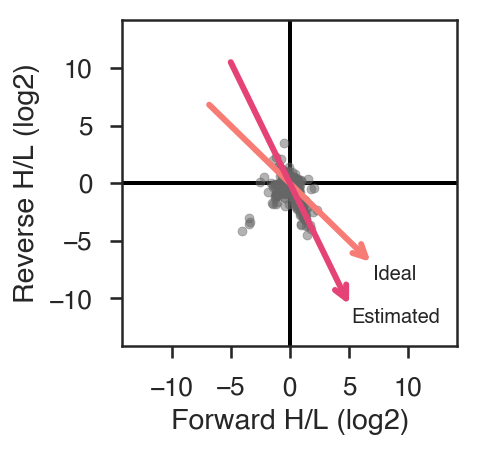

In [22]:
_df = ratios.join(inliers).join(angles).reset_index()
# I think seaborn facetgrid is buggy when only one factor present
_df = _df[_df['Pull-Down ID'] == 'H35']

fig = plt.figure(figsize=(3,3))
ax = plt.gca()

ax.scatter(_df['forward'], _df['reverse'],
           alpha=.5, color=POINT_COLOR,
           zorder=2, s=20, rasterized=True)

plot_angle_arrow([np.pi/4], 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color=ACCENT_COLOR_DIM),
                 length=10,
                 zorder=3,
                 text='Ideal',
                 text_kws=dict(ha='left', va='top', fontsize=10),
                 ax=ax)

plot_angle_arrow(_df['estimated'], 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color=ACCENT_COLOR),
                 length=12,
                 text='Estimated',
                 text_kws=dict(ha='left', va='top', fontsize=10),
                 zorder=3, ax=ax)


# plot_title(_df['Pull-Down ID'], ax=ax)

ax.set_xlabel('Forward H/L (log2)')
ax.set_ylabel('Reverse H/L (log2)')
ax.set_title('')


for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)

zero_lines(ax=ax, linewidth=2)
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.grid(False)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.title.set_visible(False)

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'enrichment-estimated-vs-ideal.pdf'), bbox_inches='tight')

# Residual centering explanation

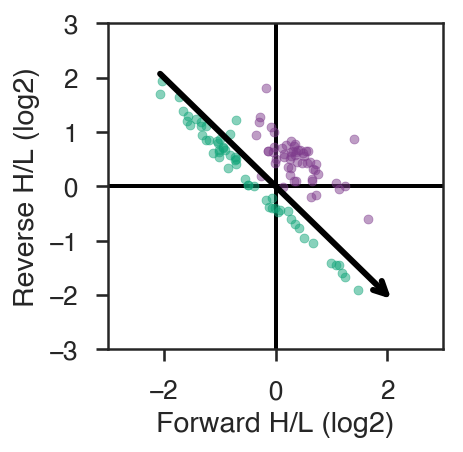

In [23]:
_df = ratios.join(inliers).join(angles).reset_index()
# I think seaborn facetgrid is buggy when only one factor present
_df = _df[_df['Gene label'].isin(['RAD50', 'SUZ12'])]

fig = plt.figure(figsize=(3,3))
ax = plt.gca()

pal = dict(zip(_df['Gene label'].unique(), palettable.cartocolors.qualitative.Bold_10.hex_colors))

for gene, subdf in _df.groupby('Gene label'):
    ax.scatter(subdf['forward'], subdf['reverse'],
               alpha=.5, color=pal[gene], label=gene,
               zorder=2, s=20, rasterized=True)

plot_angle_arrow([np.pi/4], 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color='black'),
                 length=3,
                 zorder=3,
                 text=None,
                 text_kws=dict(ha='left', va='top', fontsize=10),
                 ax=ax)

# plot_angle_arrow(_df['r-pca'], 
#                  arrowprops=dict(arrowstyle="->", linewidth=3, 
#                                  color=ACCENT_COLOR),
#                  length=12,
#                  text='Estimated',
#                  text_kws=dict(ha='left', va='top', fontsize=10),
#                  zorder=3, ax=ax)


# plot_title(_df['Pull-Down ID'], ax=ax)

ax.set_xlabel('Forward H/L (log2)')
ax.set_ylabel('Reverse H/L (log2)')
ax.set_title('')


for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)

zero_lines(ax=ax, linewidth=2)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid(False)
# ax.set_xticks([-10, -5, 0, 5, 10])
# ax.set_yticks([-10, -5, 0, 5, 10])
ax.title.set_visible(False)
# ax.legend(fontsize='smaller', title='Response across PDs')

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'residual-centering.pdf'), bbox_inches='tight')

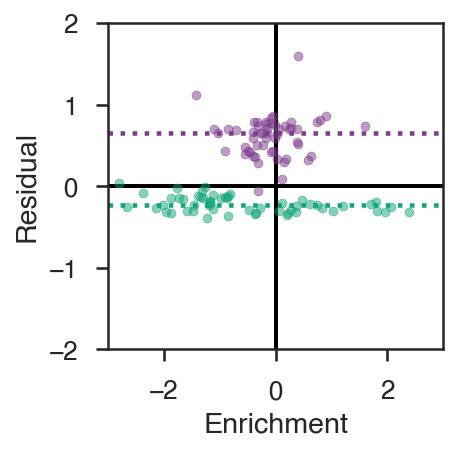

In [24]:
_df = rotated.join(inliers).join(angles).reset_index()

# I think seaborn facetgrid is buggy when only one factor present
_df = _df[_df['Gene label'].isin(['RAD50', 'SUZ12'])]

fig = plt.figure(figsize=(3,3))
ax = plt.gca()

pal = dict(zip(_df['Gene label'].unique(), palettable.cartocolors.qualitative.Bold_10.hex_colors))

for gene, subdf in _df.groupby('Gene label'):
    ax.scatter(subdf['Enrichment'], subdf['Residual'],
               alpha=.5, color=pal[gene], label=gene,
               zorder=2, s=20, rasterized=True)
    
    ax.axhline(subdf['Residual'].median(), linestyle=':', color=pal[gene],
               zorder=1)


# plot_title(_df['Pull-Down ID'], ax=ax)

ax.set_xlabel('Enrichment')
ax.set_ylabel('Residual')
ax.set_title('')


for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)

zero_lines(ax=ax, linewidth=2)
ax.set_xlim(-3, 3)
ax.set_ylim(-2, 2)
ax.grid(False)
# ax.set_xticks([-10, -5, 0, 5, 10])
# ax.set_yticks([-10, -5, 0, 5, 10])
ax.title.set_visible(False)
# ax.legend(fontsize='smaller')

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'residual-centering-rotated.pdf'), bbox_inches='tight')

# Statistical testing

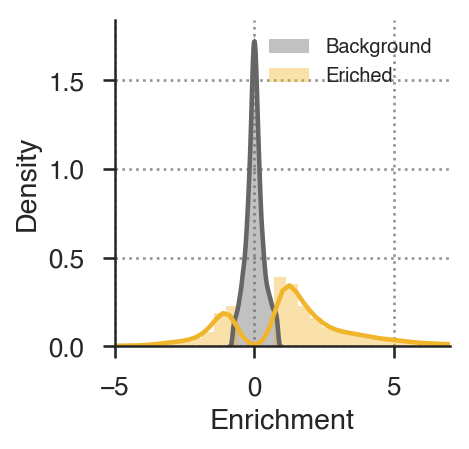

In [25]:
fig = plt.figure(figsize=(3,3))
ax = plt.gca()
for significant in [False, True]:
    
    mask = enrichment_data['significant'] == significant
    subdata = enrichment_data.loc[mask]
    
    if significant:
        label = 'Eriched'
        color = ACCENT_COLOR_3
    else:
        label = 'Background'
        color = POINT_COLOR
    
    sns.distplot(subdata['Enrichment'], label=label, color=color, ax=ax)
    
ax.set_ylabel('Density')
ax.set_xlabel('Enrichment')
ax.set_xlim(-5, 7)
ax.legend(fontsize=10, loc='upper right')
# enrichment_data[enrichment_data['significant'].isnull()]

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'statistics-density-plot.pdf'), bbox_inches='tight')

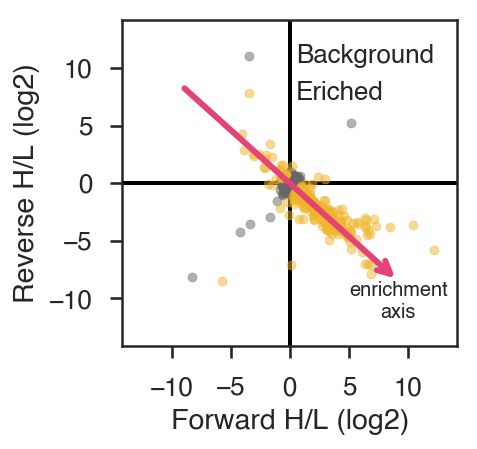

In [26]:
import matplotlib.transforms as transforms

_df = ratios.join(inliers).join(angles).join(enrichment_data['significant']).reset_index()
# I think seaborn facetgrid is buggy when only one factor present
_df = _df[_df['Pull-Down ID'] == 'H42']

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


for significant, subdf in _df.groupby('significant'):
    if significant:
        label = 'Eriched'
        color = ACCENT_COLOR_3
    else:
        label = 'Background'
        color = POINT_COLOR
        
    ax.scatter(subdf['forward'], subdf['reverse'],
               alpha=.5, color=color, label=label,
               zorder=2, s=20, rasterized=True)

angle = np.unique(_df['estimated'])[0]

plot_angle_arrow(_df['estimated'], 
                 arrowprops=dict(arrowstyle="->", linewidth=3, 
                                 color=ACCENT_COLOR),
                 length=12.5,
                 text='enrichment\naxis',
                 text_kws=dict(ha='center', va='top', fontsize=10),
                 zorder=3, ax=ax)


# plot_title(_df['Pull-Down ID'], ax=ax)

ax.set_xlabel('Forward H/L (log2)')
ax.set_ylabel('Reverse H/L (log2)')
ax.set_title('')


for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)

zero_lines(ax=ax, linewidth=2)
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.grid(False)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.title.set_visible(False)
ax.legend(fontsize='small')

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'statistics-scatter-plot.pdf'), bbox_inches='tight')

In [27]:
n_significant = enrichment_data.groupby(level='Pull-Down ID')['significant'].sum()
n_nonzero = (~ratios.isnull()).all(axis=1).groupby(level='Pull-Down ID').sum()

_df = pd.DataFrame({'# Enriched proteins': n_significant, '# Total proteins': n_nonzero})

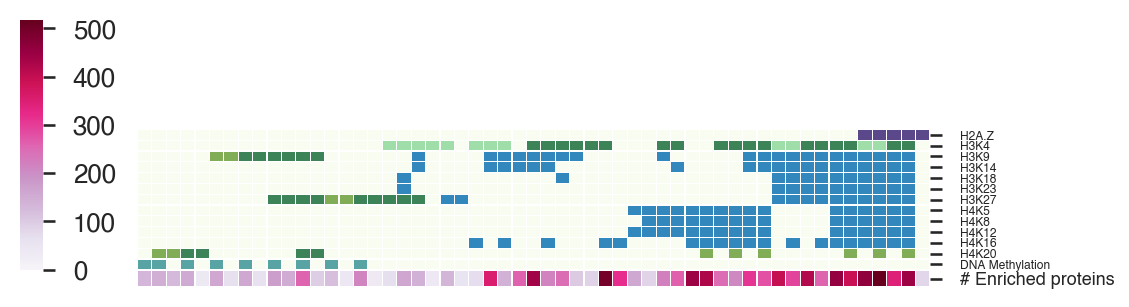

In [28]:
from snapanalysis.visualisation.heatmaps.pattern_heatmap import standard_clustermap

clustermap = standard_clustermap(_df[['# Enriched proteins']].T, predictors_directionalised=False, 
                                 global_cluster=True,
                                 cmap='PuRd',
                                 vmin=0,
                                 center=None,
                                 row_cluster=False)

for label in clustermap.ax_heatmap.get_yticklabels():
    label.set_rotation(0)
    
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'n-enriched-heatmap.pdf'), bbox_inches='tight')

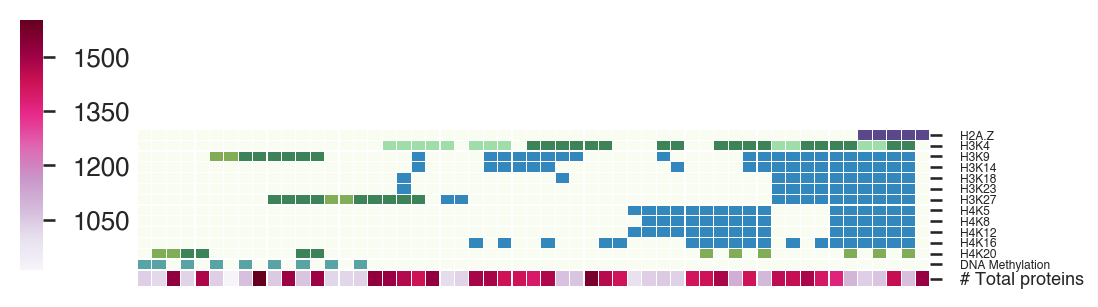

In [29]:
from snapanalysis.visualisation.heatmaps.pattern_heatmap import standard_clustermap

clustermap = standard_clustermap(_df[['# Total proteins']].T, predictors_directionalised=False, 
                                 global_cluster=True,
                                 cmap='PuRd',
#                                  vmin=0,
                                 center=None,
                                 row_cluster=False)

for label in clustermap.ax_heatmap.get_yticklabels():
    label.set_rotation(0)
    
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'n-total-heatmap.pdf'), bbox_inches='tight')

# Histones

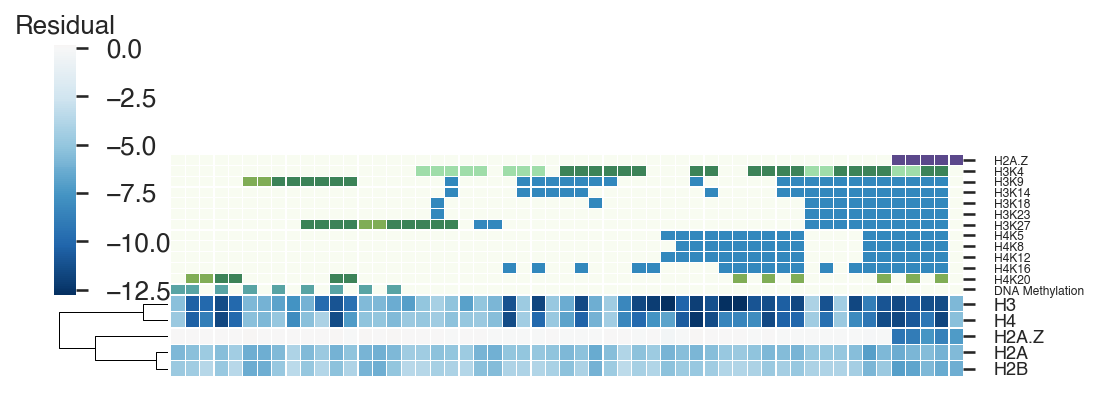

In [30]:
import scipy.cluster.hierarchy


histones = { 
            'HIST1H2AD/H2AFJ': 'H2A',
            'HIST1H3[A-J]': 'H3',
            'HIST[1H4A,1H4B,1H4C,1H4E,1H4F,1H4H,1H4I,1H4L,2H4A,4H4]': 'H4',
            'H2AFV/H2AFZ': 'H2A.Z',
            'HIST1H2B[C,D,E,F,G,I]': 'H2B'}

# Not showing bias
#             'HIST1H2BD',
#             'HIST1H2BK/LOC102724334',
#             'HIST1H2BM',
#             'HIST1H2BN',
            
#             'HIST1H2B[H,L]/HIST2H2BF',
#             'HIST2H2BE',
            
#                'HIST1H2A[G-M]/HIST2H2A[A3,A4,C]/H2AFJ', 
#             'HIST1H2A[B,E]/HIST3H2A',
            
#             'H3F3[A,B,C]',
#             'HIST[2H3A,2H3C,2H3D,3H3]',
            
_df = enrichment_data.loc[list(histones.keys())]['Residual'].unstack('Pull-Down ID')

clustermap = standard_clustermap(_df.fillna(0), 
                                 mask=_df.isnull(), 
                                 predictors_directionalised=False, 
                                 global_cluster=True,
                                 yticklabels=[histones[ix] for ix in _df.index],
                                 row_cluster=True)

clustermap.cax.yaxis.set_tick_params(labelsize='smaller')
clustermap.cax.set_title('Residual', fontsize='smaller')

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'histone-residuals.pdf'), bbox_inches='tight')

In [31]:
_df = []

for key, value in histones.items():
    
    _dff = ratios.copy()
    _dff['Histone'] = value
    _dff['Show'] = False
    _dff.loc[key, 'Show'] = True
    _df.append(_dff)
    
_df = pd.concat(_df).reset_index()

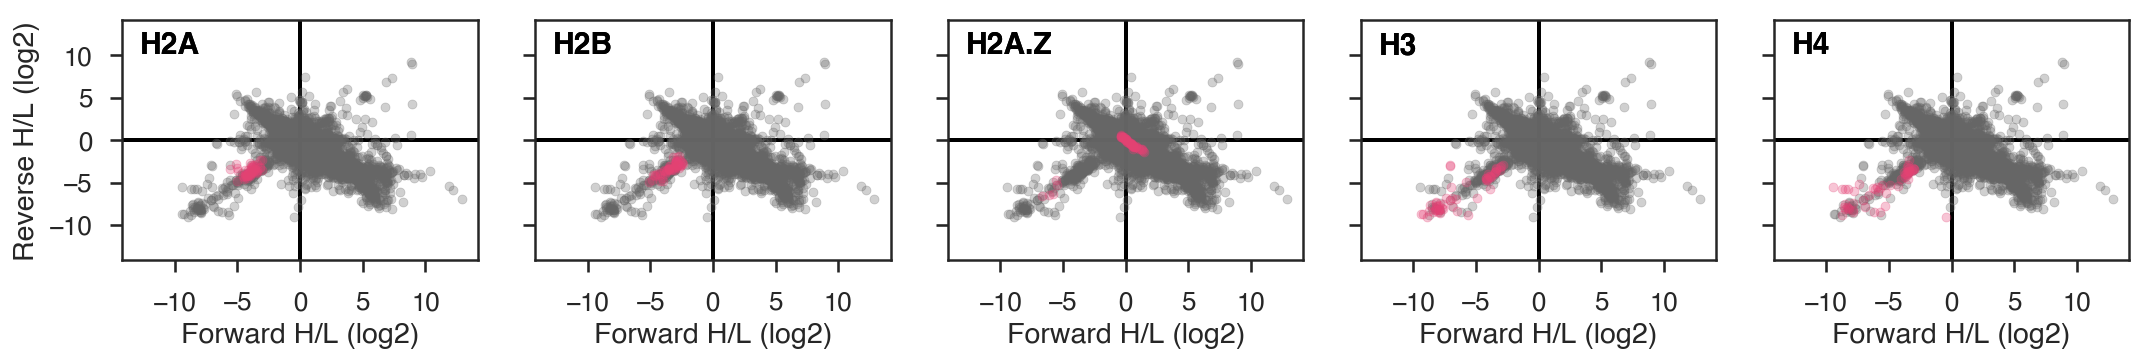

In [32]:
# _df = ratios.loc[list(histones.keys())].reset_index()
_df['Gene label'] = _df['Gene label'].replace(histones)

fgrid = sns.FacetGrid(data=_df,
                      col='Histone',
                      hue='Show',
                      palette={True: ACCENT_COLOR, False: POINT_COLOR},
                      col_order=['H2A', 'H2B', 'H2A.Z', 'H3', 'H4'],
                      hue_order=[False, True],
                      col_wrap=5)

fgrid.map(plt.scatter, 'forward', 'reverse',
          alpha=.3,
          zorder=2, s=20, rasterized=True)

#
fgrid.map(plot_title, 'Histone', pos='top')

fgrid.set_xlabels('Forward H/L (log2)')
fgrid.set_ylabels('Reverse H/L (log2)')


for i, ax in enumerate(fgrid.axes):
    for side in ['top', 'right', 'left', 'bottom']:
        ax.spines[side].set_visible(True)

    zero_lines(ax=ax, linewidth=2)
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.grid(False)
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.title.set_visible(False)

fgrid.savefig(os.path.join(OUTPUT_DIRECTORY, f'histones-scatter-plot.pdf'))

In [33]:
enrichment_data['Ratio H/L normalized (log2) (adjusted, imputed, forward)'].loc['HIST1H3[A-J]', 'H07M']

-0.8651294645676711

In [34]:
from snapanalysis.models.network.training import load_matrix
matrix, __, __ = load_matrix()

2020-05-08 15:55:56,124 - snapanalysis.snapanalysis.models.network.training - INFO - 1,920/1,920 genes (100.00%) have min_significant >= 0
2020-05-08 15:55:56,515 - snapanalysis.snapanalysis.models.network.training - INFO - Removed 5 (0.26%) rows due to them being all-zero


In [35]:
matrix.loc[list(histones.keys())].median(axis=1)

Gene label
HIST1H2AD/H2AFJ                                          -0.135367
HIST1H3[A-J]                                              0.005268
HIST[1H4A,1H4B,1H4C,1H4E,1H4F,1H4H,1H4I,1H4L,2H4A,4H4]   -0.049090
H2AFV/H2AFZ                                               0.371194
HIST1H2B[C,D,E,F,G,I]                                    -0.022264
dtype: float64